   # Задача бинарной классификации для Телеком

## Выгрузка данных

In [1]:
import pandas as pd
import numpy as np
from io import BytesIO
import requests
from matplotlib import pyplot as plt
import seaborn as sns 

import phik
from phik.report import plot_correlation_matrix


from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



In [2]:
#функция для открытия файлов

def open_file(file):
    spreadsheet_id = file
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    df = pd.read_csv(BytesIO(r.content))
    return df 

In [3]:
#формируем таблички

contract = open_file('1jzH2Tk1K6t_VGHjYLhib3oT2u1NDy9qZWecsRVsoOkk')
internet = open_file('1FEW-SHRUqSWNofsfefxO4dv53nj-jfPK8yrSrCpqRms')
personal = open_file('1IpximJNGrueNMaoi-FnaYnbKcA9PQxG-dtN7S2FFW3c')
phone = open_file('1X3RHgS2W9ZnFY6q6vyV-BkLKkTCWXp9sUk76nTQfRns')

#### Таблица Contract

In [4]:
print(contract.info())
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 0:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 0:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


#### Таблица Internet

In [5]:
print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


#### Таблица Personal

In [6]:
print(personal.info())
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


#### Таблица phone

In [7]:
print(phone.info())
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Выводы


При просмотре данных я обратила внимание на то, что размерность таблиц разная. Это произошло потому, что есть клиенты которые пользуются одной услугой, например, телефонией и тогда, в таблице "Интернет" данного клиента не будет.
Во избежание пустот при схлапывании таблиц, я сделаю в каждой таблице для клиента пометку:
признак "пользуется услугами связи"(use_phone) и значение 0 и 1, где 0 - не пользуется, 1 - пользуется.
и признак "пользуется услугами интернета"(use_internet) и значение 0 и 1,  где 0 - не пользуется, 1 - пользуется. 
Таким образом, нам удастся избежать пропусков, а так же данные столбцы будут дополнительными признаками в предсказании моделей.

Так же, я обратила внимание, что в таблице contract есть пропуски в столбце TotalCharges. Предполагаю, что их можно будет восстановить исходя из данных других столбцов, а именно из столбца даты заключения контракта.

Задача "прогноз оттока клиентов" - это категориальная задача. 
В основном в таблицах мы имеем категориальные признаки, и только два столбца количественных признака. Возможно, предеться заменять значения Yes/No на 1/0, но пока это лишь предположение.
Безусловно, не все столбцы понадобятся нам для построения модели  машинного обучения.

Целевой признак мы явно наблюдаем в столбце EndDate - если дата ухода проставлена, то этот клиент для нас положительный класс-ушедший клиентв. если в столбце EndDate установлена No, то клиент имеет отрицательный класс,то бишь клиент который остался.

## Подготовка данных и EDA

Исходя из всего вышесказанного, подготовим данные для анализа.

In [8]:
#создадим в таблице phone и internet признак, что клиент использует эту услугу.
phone['use_phone'] = 1
internet['use_internet'] = 1

In [9]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,use_internet
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,1
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,1
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,1
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,1


In [10]:
phone.head()

,customerID,MultipleLines,use_phone
0,5575-GNVDE,No,1
1,3668-QPYBK,No,1
2,9237-HQITU,No,1
3,9305-CDSKC,Yes,1
4,1452-KIOVK,Yes,1


Провелили, что изменения данных успешно произведены.

Соберем из четырех таблиц одну, методом merge()

In [11]:
df_one = contract.merge(phone, on='customerID', how='outer')
df_one = df_one.merge(internet, on='customerID', how='outer')
df = df_one.merge(personal, on='customerID', how='outer')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   MultipleLines     6361 non-null   object 
 9   use_phone         6361 non-null   float64
 10  InternetService   5517 non-null   object 
 11  OnlineSecurity    5517 non-null   object 
 12  OnlineBackup      5517 non-null   object 
 13  DeviceProtection  5517 non-null   object 
 14  TechSupport       5517 non-null   object 
 15  StreamingTV       5517 non-null   object 
 16  StreamingMovies   5517 non-null   object 


1. Пустоты в столбцах  use_phone и use_internet заменяем на 0, что будет означать что клиент не пользуется данной услугой.


2. Пустоты в столбце TotalCharges(суммарные платежи) обусловлены тем, что по новым клиентам еще выгрузка не сформировалась. Все клиенты, у которых пусто в данном столбце, пришли в компанию именно в феврале 2020года(месяц выгрузки данных). Поэтому, по сути для новых клиентов столбец TotalCharges = MonthlyCharges. Оттуда данные мы и возьмем.


3. В столбцах MultipleLines, InternetService, OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies пропуски образовались потому, что клиент не пользуется услугами данного сервиса, поэтому все пустоты заменим на "No".

### Работа с дубликатами

In [13]:
df.duplicated().sum()

0

### Работа с пропусками

In [14]:
#заполним образовавшиеся пустоты в столбцах use_phone и use_internet на 0
df['use_phone'] = df['use_phone'].fillna(0)
df['use_internet'] = df['use_internet'].fillna(0)

In [15]:
# смотрим пропуски в столбце TotalCharges
df[df['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,use_phone,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,use_internet,gender,SeniorCitizen,Partner,Dependents
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,NaN,0.0,...,No,Yes,Yes,Yes,No,1.0,Female,0,Yes,Yes
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Male,0,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,No,1.0,...,Yes,Yes,No,Yes,Yes,1.0,Female,0,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Yes,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Male,0,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,NaN,0.0,...,Yes,Yes,Yes,Yes,No,1.0,Female,0,Yes,Yes
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Male,0,Yes,Yes
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Yes,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Male,0,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Female,0,Yes,Yes
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,Male,0,Yes,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Yes,1.0,...,Yes,Yes,Yes,Yes,No,1.0,Female,0,Yes,Yes


Все клиенты, у которых пусто в столбце TotalCharges, пришли в компанию именно в феврале 2020года(месяц выгрузки данных). Поэтому, по сути для новых клиентов столбец TotalCharges = MonthlyCharges.

In [16]:
df = df.fillna(value={'TotalCharges': (df['MonthlyCharges']*1)})

In [17]:
df[['MonthlyCharges','TotalCharges']].iloc[6670]

MonthlyCharges    73.35
TotalCharges      73.35
Name: 6670, dtype: float64

In [18]:
df = df.fillna('No')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   MultipleLines     7043 non-null   object 
 9   use_phone         7043 non-null   float64
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


### Целевой признак

Выделим целевой признак в таблице. По всем клиентам, которые имеют дату завершения контракта установим - 1 , то есть клиент ушел. По остальным клиентам - 0, то есть клиент остался в компании.

In [20]:
def create_target(series):
    if series == 'No':
        return 0
    else:
        return 1

In [21]:
df['target'] = df['EndDate'].apply(create_target)

In [22]:
df[['target', 'EndDate']]

,target,EndDate
0,0,No
1,0,No
2,1,2019-12-01 0:00:00
3,0,No
4,1,2019-11-01 0:00:00
...,...,...
7038,0,No
7039,0,No
7040,0,No
7041,1,2019-11-01 0:00:00


In [23]:
df['target'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: target, dtype: float64

Целевой признак обозначен.
Относительно балансировки классов мы видим, что наблюдается дисбаланс.

Оданко, не всегда есть необходимость балансировать классы. В статье Александра Дьяконова (<a href='https://dyakonov.org/2021/05/27/imbalance/ '>статья</a>) описан как раз такой случай: "Если используется ROC AUC, то перебалансировка и многие другие рецепты не влияют на значение функционала (будет изменение в третьем знаке после запятой)". А так же, я убедилась в этом на собственном опыте, когда решала задачу оттока клиентов в рамках обучения в Яндекс практикуме.
Поэтому балансировку класса в данном проекте я делать не буду.

### Добавление признаков 

Далее, добавим новый признак - так называемый "срок жизни клиента", означающий сколько времени человек был клиентом данной компании.

In [24]:
def customer_lifetime(df):
    if df['EndDate'] == 'No':
        df['EndDate'] = '2020-02-01'
        
    df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
    df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
    delta = df['EndDate'] - df['BeginDate'] 
    return delta

In [25]:
df['customer_lt'] = df.apply(customer_lifetime,axis=1)
df['customer_lt'] = df['customer_lt'].dt.days.astype('int16')

In [26]:
df[['customer_lt', 'EndDate', 'BeginDate']]

,customer_lt,EndDate,BeginDate
0,31,No,2020-01-01
1,1036,No,2017-04-01
2,61,2019-12-01 0:00:00,2019-10-01
3,1371,No,2016-05-01
4,61,2019-11-01 0:00:00,2019-09-01
...,...,...,...
7038,730,No,2018-02-01
7039,2191,No,2014-02-01
7040,337,No,2019-03-01
7041,123,2019-11-01 0:00:00,2019-07-01


### Поиск аномалий 

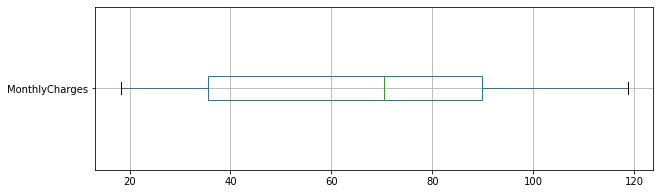

In [27]:
df.boxplot(column=['MonthlyCharges'], vert=False, figsize=(10,3));

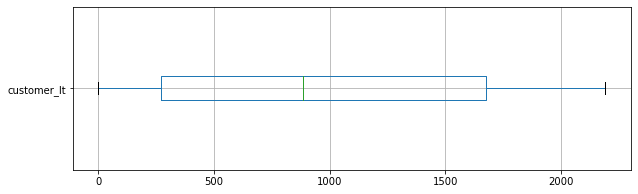

In [28]:
df.boxplot(column=['customer_lt'], vert=False, figsize=(10,3));

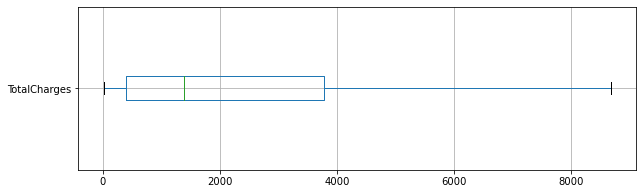

In [29]:
df.boxplot(column=['TotalCharges'], vert=False, figsize=(10,3));

In [30]:
df[df['TotalCharges'] > 6000].head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,use_phone,...,TechSupport,StreamingTV,StreamingMovies,use_internet,gender,SeniorCitizen,Partner,Dependents,target,customer_lt
15,3655-SNQYZ,2014-05-01,No,Two year,No,Credit card (automatic),113.25,7895.15,Yes,1.0,...,Yes,Yes,Yes,1.0,Female,0,Yes,Yes,0,2102
17,9959-WOFKT,2014-03-01,No,Two year,No,Bank transfer (automatic),106.70,7382.25,Yes,1.0,...,No,Yes,Yes,1.0,Male,0,No,Yes,0,2163
28,5248-YGIJN,2014-02-01,No,Two year,Yes,Credit card (automatic),90.25,6369.45,Yes,1.0,...,Yes,Yes,Yes,1.0,Male,0,Yes,No,0,2191
30,3841-NFECX,2014-03-01,No,Two year,Yes,Credit card (automatic),96.35,6766.95,Yes,1.0,...,Yes,No,No,1.0,Female,1,Yes,No,0,2163
35,6234-RAAPL,2014-02-01,No,Two year,No,Bank transfer (automatic),99.90,7251.70,Yes,1.0,...,Yes,Yes,No,1.0,Female,0,Yes,Yes,0,2191
56,8769-KKTPH,2014-11-01,No,One year,Yes,Credit card (automatic),99.65,6311.20,Yes,1.0,...,No,Yes,Yes,1.0,Female,0,Yes,Yes,0,1918
57,5067-XJQFU,2014-08-01,No,One year,Yes,Electronic check,108.45,7076.35,Yes,1.0,...,Yes,Yes,Yes,1.0,Male,1,Yes,Yes,0,2010
59,5954-BDFSG,2014-02-01,No,Two year,Yes,Credit card (automatic),107.50,7853.70,Yes,1.0,...,Yes,Yes,Yes,1.0,Female,0,No,No,0,2191
72,1891-QRQSA,2014-10-01,No,Two year,Yes,Bank transfer (automatic),111.60,7099.00,Yes,1.0,...,Yes,Yes,Yes,1.0,Male,1,Yes,Yes,0,1949
75,2673-CXQEU,2015-06-01,No,One year,No,Electronic check,110.50,6139.50,Yes,1.0,...,No,Yes,Yes,1.0,Female,1,No,No,0,1706


В столбце TotalCharges есть значения,не попадающие в диапазон нормальных значений распределения. Однако мы видим, что такие большие суммы обусловлены тем, что клиенты давно пользуются услугами компании,поэтому имеют такой финальный чек. Плюс ко всему, если такие "выбросы" удалить из тренировочных данных, то на реальных данных машина будет иметь плохой показатель метрики. поэтому пока этот признак оставляем. Посмотрим на зависимость этого признака с другими и уже потом примем окончательное решение.

### Поиск зависимостей в признаках

In [31]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'MultipleLines',
       'use_phone', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'use_internet', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'target', 'customer_lt'],
      dtype='object')

In [32]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'use_phone', 'use_internet', 'SeniorCitizen', 'target', 'customer_lt']


D:\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable customerID is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.
  warnings.warn(


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,use_phone,...,TechSupport,StreamingTV,StreamingMovies,use_internet,gender,SeniorCitizen,Partner,Dependents,target,customer_lt
customerID,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
BeginDate,1.0,1.00,0.58,0.77,0.08,0.46,0.42,0.82,0.43,0.03,...,0.40,0.36,0.37,0.13,0.01,0.05,0.47,0.21,0.50,1.00
EndDate,1.0,0.58,1.00,0.36,0.16,0.21,0.32,0.25,0.03,0.01,...,0.13,0.05,0.05,0.19,0.00,0.12,0.12,0.13,1.00,0.41
Type,1.0,0.77,0.36,1.00,0.11,0.28,0.39,0.51,0.07,0.00,...,0.18,0.07,0.07,0.15,0.00,0.09,0.18,0.15,0.25,0.66
PaperlessBilling,1.0,0.08,0.16,0.11,1.00,0.37,0.47,0.21,0.25,0.02,...,0.06,0.34,0.33,0.48,0.00,0.24,0.01,0.17,0.30,0.00
PaymentMethod,1.0,0.46,0.21,0.28,0.37,1.00,0.40,0.35,0.34,0.00,...,0.27,0.38,0.38,0.54,0.00,0.29,0.24,0.22,0.45,0.38
MonthlyCharges,1.0,0.42,0.32,0.39,0.47,0.40,1.00,0.76,0.68,0.83,...,0.58,0.84,0.83,1.00,0.01,0.30,0.20,0.18,0.36,0.41
TotalCharges,1.0,0.82,0.25,0.51,0.21,0.35,0.76,1.00,0.61,0.20,...,0.57,0.66,0.67,0.56,0.00,0.15,0.42,0.11,0.28,0.84
MultipleLines,1.0,0.43,0.03,0.07,0.25,0.34,0.68,0.61,1.00,0.42,...,0.16,0.39,0.39,0.32,0.00,0.22,0.22,0.03,0.06,0.43
use_phone,1.0,0.03,0.01,0.00,0.02,0.00,0.83,0.20,0.42,1.00,...,0.15,0.03,0.05,0.27,0.00,0.00,0.02,0.00,0.00,0.00


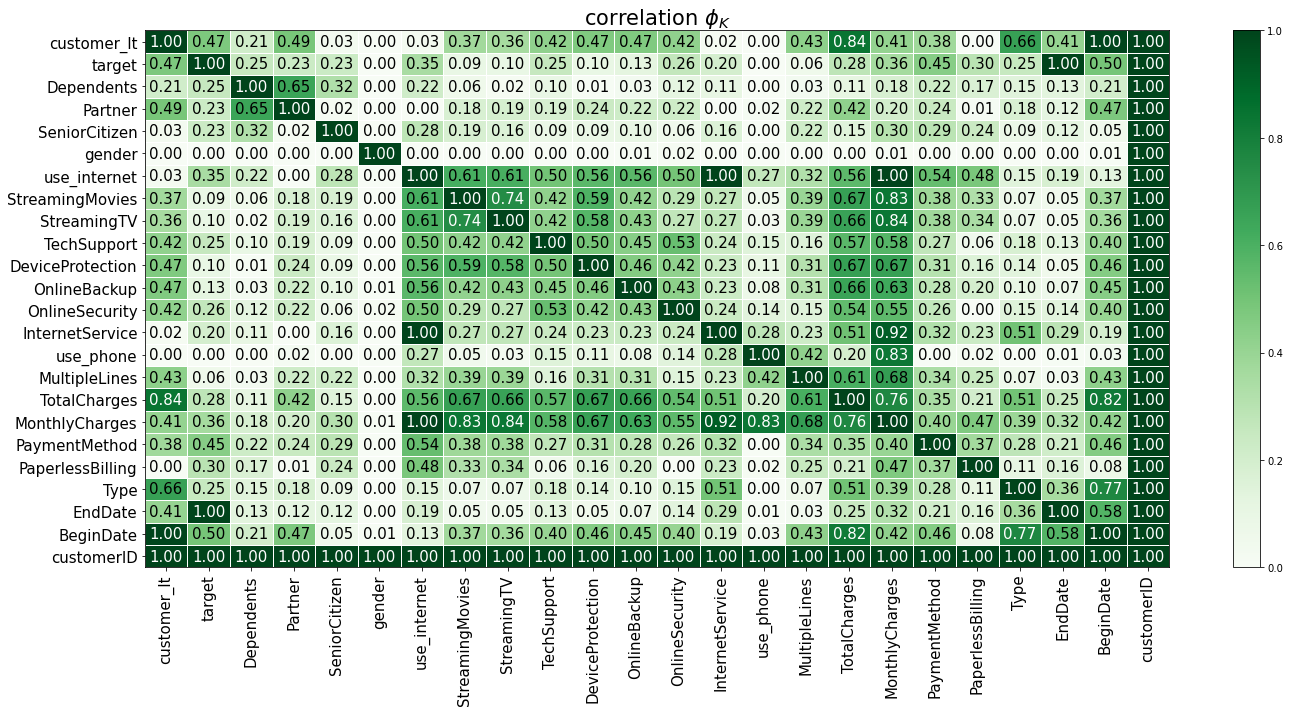

In [33]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

На хитмапе отчетливо видна корреляция следующих столбцов: EndDate, BeginDate, customerID, MonthlyCharges,InternetService, TotalCharges.

Что бы избежать переобучения модели, удалим эти признаки.


In [34]:
df = df.drop(['BeginDate','EndDate','customerID', 'MonthlyCharges','TotalCharges','InternetService'],axis=1)

interval columns not set, guessing: ['use_phone', 'use_internet', 'SeniorCitizen', 'target', 'customer_lt']


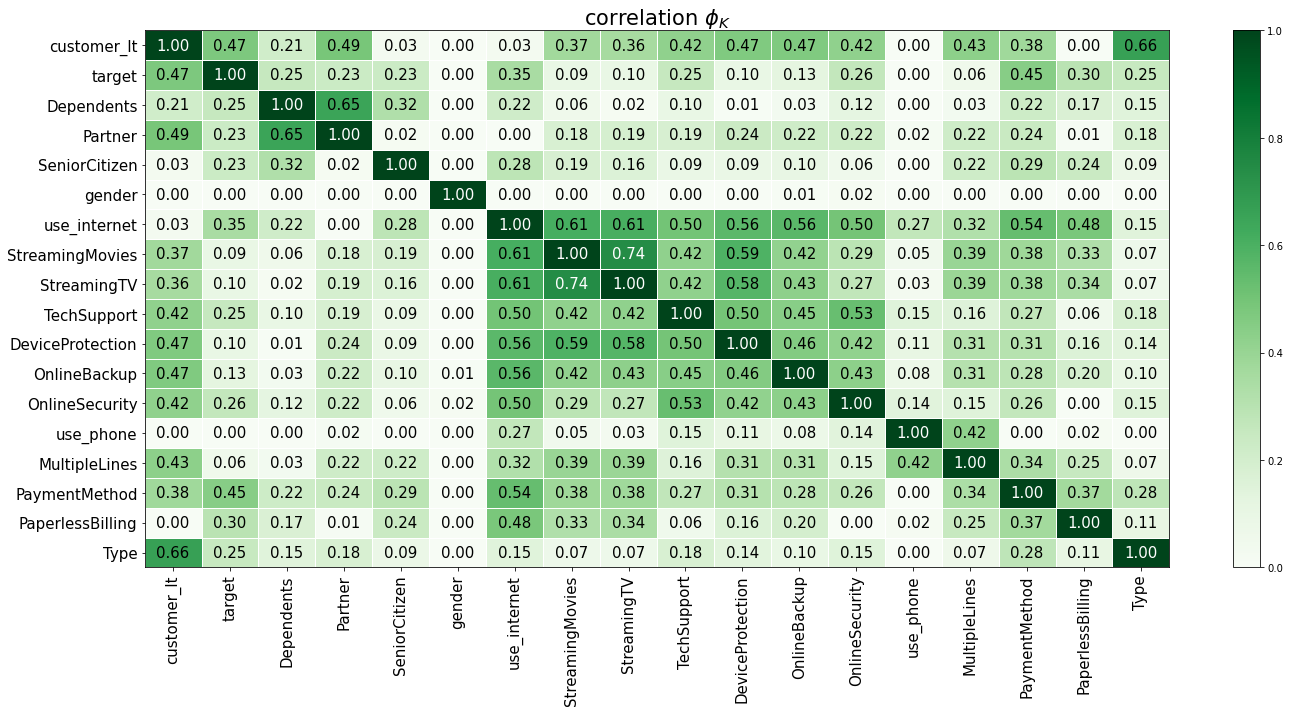

In [35]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

Теперь данные готовы к работе. Самое высокое значение корреляции в данный момент - 0,66пп.

Приступим к обучению модели.

# Построение модели машинного обучения

Напишем несколько функций:

In [36]:
#Функция для построения ROC-кривой
def func_auc_roc(model,features,target):
    model.fit(features,target)
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]#берем только положительную вероятность
    fpr, tpr, thresholds = roc_curve(target,probabilities_one)
    plt.figure();
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.show();
    auc = roc_auc_score(target,probabilities_one)
    print('Метрика ROC-AUC равна:', auc)

In [37]:
#функция для подсчета метрик
def counting_metrics(model,features,target):
    score_RA = cross_val_score(model, features, target, cv=5, scoring='roc_auc')
    score_RA_train = score_RA.mean()
    
    score_acc = cross_val_score(model, features, target, cv=5, scoring='accuracy')
    score_acc_train = score_acc.mean()
    
    print('Среднее значение метрики ROC-AUC на тренировочной выборке равно: ',score_RA_train)
    print('Среднее значение метрики Accuracy на тренировочной выборке равно: ',score_acc_train)


### CatBoostClassifier

Используем данную модель, так как она умеет работать с категориальными признаками без кодирования.

In [38]:
train, test = train_test_split(df, test_size=0.25, random_state=290822)

#проверяем обьем выборок,деление произошло корректно
print('Размерность обучающей выборки: ', train.shape)
print('Размерность тестовой выборки: ', test.shape)

Размерность обучающей выборки:  (5282, 18)
Размерность тестовой выборки:  (1761, 18)


In [39]:
#фичи и таргет
X = ['Type', 'PaperlessBilling', 'PaymentMethod', 
       'MultipleLines', 'use_phone', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'use_internet', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'customer_lt']

#категориальные признаки
cat_features = ['Type','PaperlessBilling', 'PaymentMethod', 'MultipleLines', 
                'OnlineSecurity', 'OnlineBackup','DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies','gender','Partner', 'Dependents']

y = ['target']

In [40]:
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features
                 )

In [41]:
parametres = {'cat_features': cat_features,
              'loss_function': 'Logloss',
              'eval_metric': 'AUC',
              'random_seed': 290822,
              'verbose':False}

In [42]:
# запускаем кросс-валидацию
#cv_data = cv(
#    params = parametres,
#    pool = train_data,
#    fold_count=5,
#    shuffle=True,
#    partition_random_seed=290822,
#    stratified=False,
#    plot=True, 
#    verbose=False,
#    early_stopping_rounds=200
#)

In [43]:
model_cb = CatBoostClassifier(**parametres)

In [44]:
counting_metrics(model_cb,train[X],train[y])

Среднее значение метрики ROC-AUC на тренировочной выборке равно:  0.9019591175477462
Среднее значение метрики Accuracy на тренировочной выборке равно:  0.8536509847768127


### Другие модели

Сделаем все признаки числовыми  с помощью кодировщика OHE и опробуем другие модели.

In [45]:
df_ohe = df.copy()

In [46]:
df_ohe = pd.get_dummies(df_ohe, drop_first=True)#избегаем дамми-ловушку.
df_ohe.head()

,use_phone,use_internet,SeniorCitizen,target,customer_lt,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes
0,0.0,1.0,0,0,31,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
1,1.0,1.0,0,0,1036,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
2,1.0,1.0,0,1,61,0,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
3,0.0,1.0,0,0,1371,1,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
4,1.0,1.0,0,1,61,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
train_set, test_set = train_test_split(df_ohe, test_size=0.25, random_state=290822)

#проверяем обьем выборок,деление произошло корректно
print('Размерность обучающей выборки: ', train_set.shape)
print('Размерность тестовой выборки: ', test_set.shape)

Размерность обучающей выборки:  (5282, 21)
Размерность тестовой выборки:  (1761, 21)


In [48]:
train_features = train_set.drop('target',axis=1) 
train_target = train_set['target']

test_features = test_set.drop('target',axis=1)
test_target = test_set['target']

### DummyClassifier

In [49]:
dummy_clf = DummyClassifier()

In [50]:
counting_metrics(dummy_clf,train_features,train_target)

Среднее значение метрики ROC-AUC на тренировочной выборке равно:  0.5
Среднее значение метрики Accuracy на тренировочной выборке равно:  0.7360848312835068


### DecisionTreeClassifier

Подберем параметры для модели с помощью GridSearchCV, который использует в своем алгоритме кросс-валидацию.

In [51]:
parametrs = {'max_depth': range(1, 11)}

model_search = DecisionTreeClassifier(random_state=290822)
grid_s = GridSearchCV(model_search, parametrs, cv=5, scoring='roc_auc')
grid_s.fit(train_features, train_target)
param = grid_s.best_params_
param

{'max_depth': 7}

In [52]:
model_dtc = DecisionTreeClassifier(random_state=290822,max_depth=param.get('max_depth'))

In [53]:
counting_metrics(model_dtc,train_features,train_target)

Среднее значение метрики ROC-AUC на тренировочной выборке равно:  0.8353538767533568
Среднее значение метрики Accuracy на тренировочной выборке равно:  0.7998815615951378


### RandomForestClassifier

In [55]:
parametrs = {'n_estimators': range (10, 101, 10), 'max_depth': range(1, 11)}

model_search = RandomForestClassifier(random_state=290822)
grid_s = GridSearchCV(model_search, parametrs, cv=5, scoring='roc_auc')
grid_s.fit(train_features, train_target)
param = grid_s.best_params_
param

{'max_depth': 8, 'n_estimators': 100}

In [56]:
model_rfc = RandomForestClassifier(random_state=290822,max_depth=param.get('max_depth'),n_estimators=param.get('n_estimators'))

In [57]:
counting_metrics(model_rfc,train_features,train_target)

Среднее значение метрики ROC-AUC на тренировочной выборке равно:  0.8540283056958862
Среднее значение метрики Accuracy на тренировочной выборке равно:  0.8095386815171584


## Проверка модели на тестовой выборке

In [58]:
model_test = CatBoostClassifier(**parametres).fit(train_data)

In [59]:
predictions = model_test.predict(test[X])
acc_score = accuracy_score(test[y], predictions)
print('Метрика accuracy на тестовой выборке равна: ', acc_score)

Метрика accuracy на тестовой выборке равна:  0.8642816581487791


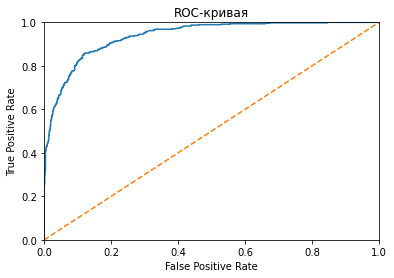

Метрика ROC-AUC равна: 0.938088728820496


In [60]:
func_auc_roc(model_test,test[X],test[y])

## Выводы

В рамках проекта удалось рассмотреть несколько моделей машинного обучения для предсказаний целевого признака.
Наилучшей моделью показала себя CatBoostClassifier, с метрикой ROC-AUC = 0.93пп.

# Отчет


В рамках данного проекта мною был подготовлен план по решению поставленной задачи от заказчика – Прогнозирование оттока клиента.



**План проекта:**


1. Предварительная обработка данных
    - открытие данных
    - ознакомление с типами данных
    - пред подготовка данных
2. Подготовка и анализ данных EDA
    - работа с дубликатами
    - обработка пропусков
    - выделение целевого признака
    - подготовка признаков
    - обнаружение аномалий
    - поиск зависимостей в данных
    - удаление признаков 
3. Построение модели машинного обучения
    - разделить выборку на тестовую и тренировочную
    - провести подбор гиперпараметров с кросс-валидацией
    - обучить несколько моделей
    - выбрать лучшую и проверить работу модели на тестовой выборке
    - метрикой качества выбрать ROC-AUC.
4. Написание отчета о проделанной работе.

Рассмотрим подробнее каждый из пунктов.

**1. Предварительная обработка данных**

При подготовке данных к анализу, первым делом необходимо просмотреть полную информацию о таблицах, предоставленных заказчиком. Используя встроенный в Pandas метод `info()` , я проанализировала, какие типы данных есть в таблицах, обратила внимание на размерность таблиц, на корректное наименование столбцов, а так же увидела, есть ли пропуски в строках. 


Задача "прогноз оттока клиентов" - это категориальная задача. В основном, в таблицах мы имеем категориальные признаки, и только два столбца количественных признака(`TotalCharges` и `MonthCharges`).

При просмотре данных я обратила внимание на то, что размерность таблиц разная. Предполагаю, что это произошло потому, что в выгрузке есть клиенты, которые пользуются одной услугой, например, телефонией. Тогда, в таблице `Internet` данного клиента не будет. 

В каждой таблице услуг  я сделаю для клиента пометку: признак "пользуется услугами связи"(`use_phone`) и признак "пользуется услугами интернета"(`use_internet`). Значения в данных столбцах будут  0 и 1, где 0 - не пользуется, 1 – пользуется. Данный способ позволит нам в дальнейшем правильно заполнить образовавшиеся пустоты, а так же данные столбцы могут послужить  дополнительными признаками в предсказании моделей. 


При предобработке данных, я также обратила внимание, что в таблице `contract` есть пропуски в столбце `TotalCharges`. Полагаю, что их можно будет восстановить исходя из данных других столбцов, а именно из столбца `BeginDate` и `MonthCharges`. 

Целевой признак мы можем явно взять из столбца `EndDate` - если дата ухода проставлена, то этот клиент для нас 1 положительный класс-ушедший клиентов, если в столбце `EndDate` установлена `No`, то клиент имеет 0 отрицательный класс, то есть клиент, который остался.
На данном этапе я собрала все данные из таблиц вместе, методом `merge()`, с параметром `how=’outer’`.


**2. Подготовка и анализ данных EDA**
-  Методом `duplicated()` проверим, есть ли *дубликаты* в данных. Их не оказалось.


-  *Пустоты* в столбцах `use_phone` и `use_internet` заменяем на 0, что будет означать что клиент не пользуется данной услугой(это известно исходя из предоставленных таблиц). 

    11 пустых ячеек в столбце `TotalCharges`(суммарные платежи) обусловлены тем, что по новым клиентам еще выгрузка не сформировалась. Все клиенты, у которых пусто в данном столбце, пришли в компанию именно в феврале 2020года (месяц выгрузки данных).  Можно предположить, что  для новых клиентов столбец `TotalCharges` = `MonthlyCharges`. И я приняла решение не удалять пустые ячейки, а заполнить их значениями.

    В столбцах `MultipleLines, InternetService, OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies` пропуски образовались потому, что клиент не пользуется услугами данного сервиса, поэтому все пустоты заменим на `No`.


- Закончив с пропусками, я приступила к выделению *целевого признака* из столбца `EndDate`. 

    Я создала дополнительный столбец `target` и в строках, где в `EndDate` есть дата окончания договора, и установила признак 1 – то есть клиент покинул компанию, в ином случае, установлен признак 0 – клиент пользуется услугами компании. 
    
    С помощью метода `value_counts()` и аргумента `normalize=True` я обнаружила, что наблюдается дисбаланс классов – 27% положительных против 73% отрицательных. 
    
    Изначально, я планировала устранить дисбаланс классов с помощью `upsampling()/downsampling()`. Однако, не всегда есть необходимость балансировать классы. В статье Александра Дьяконова  (<a href='https://dyakonov.org/2021/05/27/imbalance/ '>статья</a>) описан как раз такой случай, когда устранять баланс классов не нужно: "Если используется итоговая метрика ROC AUC, то пере балансировка и многие другие рецепты не влияют на значение функционала (будет изменение в третьем знаке после запятой)". А так же, я убедилась в этом на собственном опыте, когда решала задачу оттока клиентов в рамках обучения в Яндекс практикуме. Поэтому я приняла решение балансировку класса в данном проекте не делать.

- Далее, я приняла решение добавить еще один признак, который на мой взгляд поможет модели лучше предсказать целевое значение – признак «срок жизни клиента в компании». Я написала функцию `customer_lifetime`  для обработки столбцов `EndDate` и `BeginDate`, в которой я на выходе получала число – количество дней, в рамках которых клиент провел в компании и пользовался ее услугами. Далее эту функцию я применила к датафрейму через метод `apply()`, так как помню, что применение циклов напрямую к датафрейму очень ресурсно-затратно. По  итогу  был создан *новый столбец признак* `customer_lt`.


- После добавления признаков, мне необходимо было проверить датафрейм на *аномалии*. В категориальных признаках аномалий не обнаружилось. Для количественных  признаков я построила горизонтальную диаграмму размаха с помощью `.boxplot(vert=False, figsize=(10,3))` и обнаружила,  что в столбце `TotalCharges` есть значения > 6000, выходящие за диапазон нормальных значений распределения. Однако, исходя из данных мы видим, что такие большие суммы обусловлены тем, что клиенты давно пользуются услугами компании(дата заключения контракта), поэтому имеют такой финальный чек. Плюс ко всему, если такие "выбросы" удалить из тренировочных данных, то на реальных данных машина будет иметь плохой показатель метрики. Поэтому, я приняла решение  пока этот признак оставить нетронутым. Посмотрим на зависимость этого признака с другими и примем окончательное решение.


- Рассмотреть *зависимость признаков друг от друга* я решила с помощью тепловой карты через `phik_matrix()`  и `plot_correlation_matrix`, находящиеся в библиотеке `phik`. На тепловой карте стала  отчетливо видна корреляция следующих столбцов: `EndDate, BeginDate, customerID, MonthlyCharges, InternetService, TotalCharges`. Что бы избежать переобучения модели, я приняла решение удалить эти признаки.

**3. Построение модели машинного обучения.**

- Для начала, я написала функцию  `func_auc_roc`, которая строит график кривой ошибок. И функцию `counting_metrics`, которая считает `roc-auc` и `accuracy` на тренировочной выборке с помощью `cross_val_score()` и  возвращает их средние значения.

- Следующим шагом необходимо было разделить данные на тренировочную выборку и тестовую. Так как датасет довольно мал(7043 строки),  я не стала выделять еще и валидационную выборку, а воспользовалась кросс-валидацией и подобрала наилучшие параметры через `GridSearchCV`, посчитав средние метрики через `cross_val_score()`. 

- Датасет я разделила с помощью `train_test_split()`, тестовой выборке отвела 25% от всего датасета. В итоге получилось:
      Размерность обучающей выборки:  (5282, 18),  
      Размерность тестовой выборки:  (1761, 18)

- Первой моделью, которую я применила к предоставленным данным, стала модель CatBoostClassifier:  данная модель не требует кодирования категориальных признаков, и является одной из лучших моделей с реализацией градиентного бустинга. 

    Мною были подобраны следующие параметры для данной модели: 'cat_features': cat_features,  'loss_function': 'Logloss',  'eval_metric': 'AUC',  'random_seed': 290822, 'verbose':False.
    
    С данными параметрами модель смогла достигнуть при кросс-валидации следующие метрики:
    
    Среднее значение метрики ROC-AUC на тренировочной выборке равно:  **0.901**
    
    Среднее значение метрики Accuracy на тренировочной выборке равно:  **0.853**

- Уже очень хорошие показатели. Но я хотела бы проверить и другие модели, посмотреть, как они справятся с поставленной задачей. Выбор пал на модели: `DummyClassifier, DecisionTreeClassifier, RandomForestClassifier.`
    Данные модели не умеют работать с текстовыми категориальными признаками, поэтому прежде чем приступить к обучению модели, я провела кодирование признаков методом прямого кодирования `OHE: get_dummies()`. Обязательно установила  `drop_first=True` , что бы избежать дамми-ловушку. Снова разделив данные на тестовую и тренировочную , я получила следующие  размерности:
        Размерность обучающей выборки:  (5282, 21)
        Размерность тестовой выборки:  (1761, 21)

  Выделив целевой признак от остальных признаков, я приступила к обучению моделей. 
  
  
- `DummyClassifier` я использовала только для сравнения и обозначения некоего порогового значения метрики. 

    Модель показала предсказуемые значения `roc-auc` и интересное значение `accuracy`: 
    
    Среднее значение метрики `ROC-AUC` на тренировочной выборке равно:  **0.5**
    
    Среднее значение метрики `Accuracy` на тренировочной выборке равно:  **0.736**

- Модели `DecisionTreeClassifier, RandomForestClassifier` я сначала  подала на вход в `GridSearchCV` с одним параметром `random_state=290822`. Это сделано для того что бы  `GridSearchCV` подобрала для тренировочных данных оптимальные гиперпараметры, конечно же используя кросс-валидацию и `scoring='roc_auc'`.
    На выходе мы получили следующие оптимальные гиперпараметры:
      - {'max_depth': 7}  для `DecisionTreeClassifier`
      - {'max_depth': 8, 'n_estimators': 100} для `RandomForestClassifier`.

    С данными гиперпараметрами модели показали тоже отличные результаты метрики:
       
`DecisionTreeClassifier:`

   - Среднее значение метрики `ROC-AUC` на тренировочной выборке равно:  **0.835**
   - Среднее значение метрики `Accuracy` на тренировочной выборке равно:  **0.799**


`RandomForestClassifier: `
   - Среднее значение метрики `ROC-AUC` на тренировочной выборке равно:  **0.854**
   - Среднее значение метрики `Accuracy` на тренировочной выборке равно: **0.809**

 

**Лучшей моделью по итогам стал `CatBoostClassifier`. Его результаты на тестовой выборке:**
        
- Метрика `accuracy` на тестовой выборке равна:  **0.864**
- Метрика `ROC-AUC` равна: **0.938**

**Выводы:**

В данной задаче, я считаю, самое важное было обратить внимание на признаки:  убрать те, которые помешали бы модели корректно построить предсказания. 

В целом данные были достаточно «чистые»: не требовали сильных изменений, не имели большое количество пропусков неясной этимологии.

Это была интересная задача для меня, и я рада, что смогла решить ее на отлично.

